# Xử lý cột request

In [17]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns


1. Xử lý

In [18]:
# Lấy data từ file zip
zip_path = '../data/cleaned/data_cleaned.zip'

with zipfile.ZipFile(zip_path, 'r') as z:
    print("Danh sách file:", z.namelist())
    
    # Đọc file train
    with z.open('train.csv') as f:
        df_train = pd.read_csv(f)
        
    # Đọc file test
    with z.open('test.csv') as f: 
        df_test = pd.read_csv(f)

print(f"Đã load Train ({len(df_train)} dòng) và Test ({len(df_test)} dòng)")


Danh sách file: ['train.csv', 'test.csv']
Đã load Train (2934930 dòng) và Test (526644 dòng)


In [5]:
# Định nghĩa các hằng số phân loại
HTTP_METHODS = ['GET', 'POST', 'PUT', 'PATCH', 'DELETE', 'HEAD', 'OPTIONS', 'TRACE', 'CONNECT']
IMAGE_TYPES = ['gif', 'jpg', 'jpeg', 'tiff', 'png', 'bmp', 'xbm', 'eps', 'art', 'ps']
AV_TYPES = ['wav', 'avi', 'mp3', 'wma', 'mpg', 'ksc']
FILE_TYPES = ['doc', 'rtf', 'xls', 'txt', 'bak', 'xb', 'pdf', 'sta', 'bps', 'new', 'zip', 'bad', 'out', 'orig','dat', 'lists']
PAGE_TYPES = ['html', 'pl', 'htm', 'map', 'perl', 'dec', 'software']

In [6]:
# Tách method và URL thô
''' Tức là từ chuỗi request như "GET /index.html HTTP/1.1"
    ta sẽ tách lấy "GET" và "/index.html" 
    '''
def parse_request_basic(request):
    parts = str(request).split(' ')
    method = parts[0] if len(parts) > 0 else 'UNKNOWN'
    url = parts[1] if len(parts) > 1 else 'UNKNOWN'
    return method, url

In [7]:
# Tách Directory và Resource từ URL
''' Tức là từ URL như "/images/logo.png"
    ta sẽ tách lấy "/images/" và "logo.png"
    '''
def get_resource_details(url):
    try:
        url_clean = str(url).replace('HTTP/1.0','').strip()
        last_slash = url_clean.rindex('/')
        directory = url_clean[:last_slash+1]
        resource = url_clean[last_slash+1:]
    except:
        directory = url
        resource = '' 
    return directory, resource

In [8]:
# Phân loại resource dựa trên đuôi file
def get_resource_type(resource):
    try:
        dot_index = resource.rindex('.')
        ext = resource[dot_index+1:].lower()
        if ext in IMAGE_TYPES:
            return 'Image'
        if ext in AV_TYPES:
            return 'Audio/Video'
        if ext in FILE_TYPES:
            return 'File'
        if ext in PAGE_TYPES:
            return 'Page'
        return 'UNKNOWN'
    except:
        return 'Directory'

In [9]:
# Hàm tổng hợp chạy toàn bộ làm sạch và chuẩn hoá request
def request_pipeline(df):
    # Tách method và URL
    basic_info = df['request'].apply(parse_request_basic)
    df['reqmethod'] = [x[0] for x in basic_info]
    df['requrl'] = [x[1] for x in basic_info]

    # Chuẩn hoá method
    df['reqmethod'] = df['reqmethod'].apply(lambda x: x if x in HTTP_METHODS else 'UNKNOWN')

    # Tách directory và resource
    details = df['requrl'].apply(get_resource_details)
    df['reqdirectory'] = [x[0] for x in details]
    df['reqresource'] = [x[1] for x in details]

    # Phân loại resource
    df['reqresourcetype'] = df['reqresource'].apply(get_resource_type)

    return df

In [13]:
# chạy hàm cho file train và file test
df_train_cleaned = request_pipeline(df_train)
df_test_cleaned = request_pipeline(df_test)
print("Đã xử lý xong request cho Train và Test")

df_train_cleaned.head()

Đã xử lý xong request cho Train và Test


,host,timestamp,request,response,bytes,reqmethod,requrl,reqdirectory,reqresource,reqresourcetype
0,199.72.81.55,1995-07-01 00:00:01,GET /history/apollo/ HTTP/1.0,200,6245,GET,/history/apollo/,/history/apollo/,,Directory
1,unicomp6.unicomp.net,1995-07-01 00:00:06,GET /shuttle/countdown/ HTTP/1.0,200,3985,GET,/shuttle/countdown/,/shuttle/countdown/,,Directory
2,199.120.110.21,1995-07-01 00:00:09,GET /shuttle/missions/sts-73/mission-sts-73.ht...,200,4085,GET,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-73/,mission-sts-73.html,Page
3,burger.letters.com,1995-07-01 00:00:11,GET /shuttle/countdown/liftoff.html HTTP/1.0,304,0,GET,/shuttle/countdown/liftoff.html,/shuttle/countdown/,liftoff.html,Page
4,199.120.110.21,1995-07-01 00:00:11,GET /shuttle/missions/sts-73/sts-73-patch-smal...,200,4179,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,/shuttle/missions/sts-73/,sts-73-patch-small.gif,Image


2. Vẽ các biểu đồ

In [40]:
# Vẽ biểu đồ Top 20 non-image resources được truy cập nhiều nhất
def plot_top_non_image_resources(df_viz):
    df_viz = df_train_cleaned

    top_res = df_viz[(df_viz['reqresourcetype'] != 'Image') & (df_viz['reqresourcetype'] != 'Directory')]
    top_res = top_res.groupby(['requrl'])['requrl'].count().sort_values(ascending=False).head(20).reset_index(name='count')
    plt.figure(figsize=(16, 9))
    plt.barh(top_res['requrl'], top_res['count'], color=sns.color_palette('magma', 20))
    plt.gca().invert_yaxis()
    plt.title('Top 20 frequently accessed non-image resources (Train Set)')
    plt.grid(axis='x', linestyle='-.', alpha=0.3)
    for i, v in enumerate(top_res['count']):
        plt.text(v + 0.2, i, str(v), color='darkblue', fontweight='bold', va='center')
    plt.show()

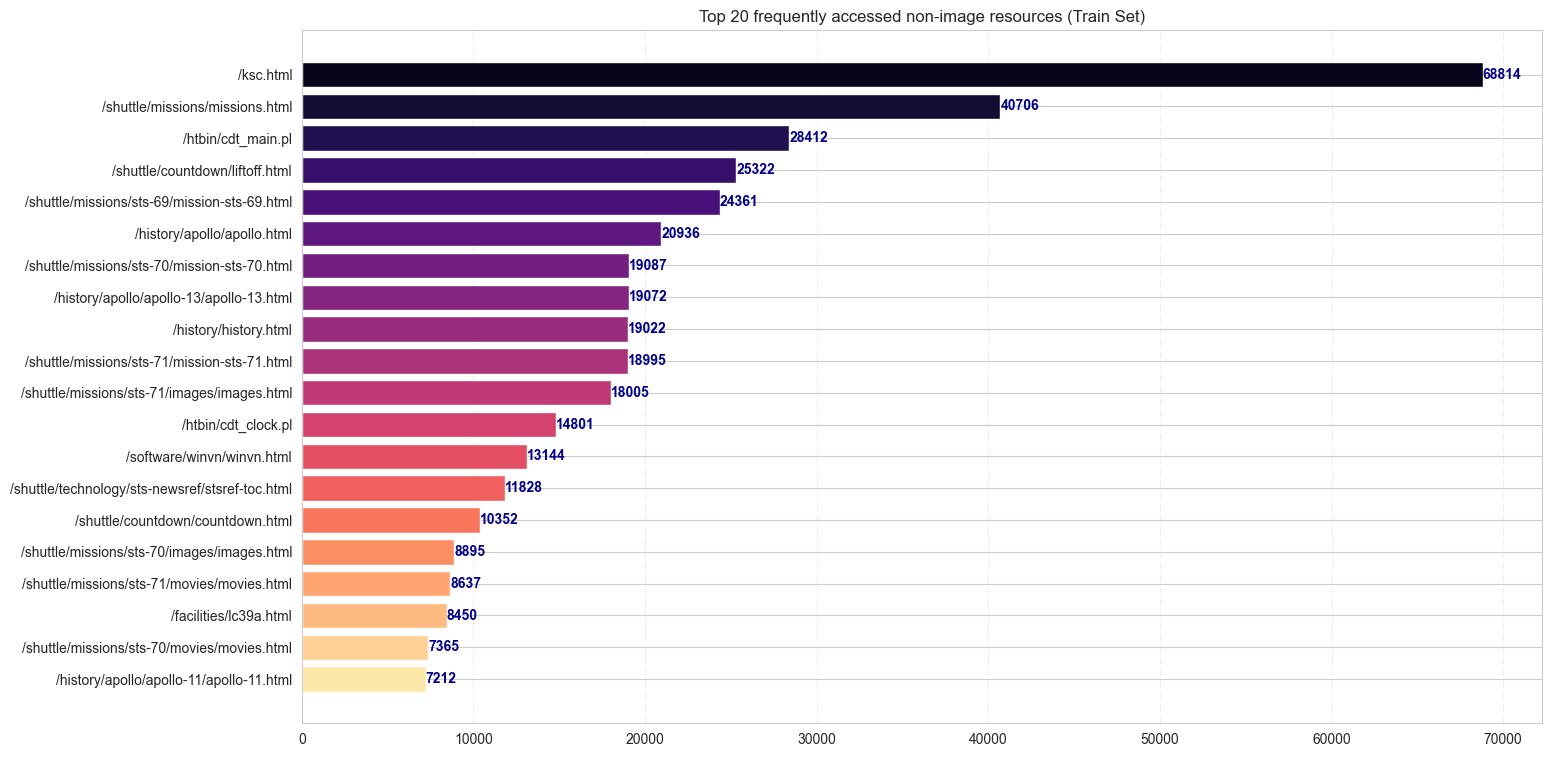

In [41]:
plot_top_non_image_resources(df_train_cleaned)

In [42]:
# Biểu đồ Top 20 thư mục (Directories) được truy cập thường xuyên nhất
def plot_top_directories(df_train_cleaned):
    # 1. Lấy dữ liệu top 20
    dir_counts = df_train_cleaned['reqdirectory'].value_counts().head(20).reset_index()
    dir_counts.columns = ['Directory', 'Count']

    # 2. Vẽ biểu đồ NGANG (y='Directory') để đọc được tên thư mục
    plt.figure(figsize=(12, 10)) # Tăng chiều cao để các hàng giãn cách
    sns.set_style("whitegrid")

    # Chú ý: x là Count, y là Directory
    ax = sns.barplot(x='Count', y='Directory', data=dir_counts, palette='magma')

    # 3. Thêm con số cụ thể ở cuối mỗi thanh để dễ so sánh
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 1000,       # Vị trí x (cách đầu thanh một khoảng)
                p.get_y() + p.get_height() / 2, # Vị trí y (giữa thanh)
                '{:,.0f}'.format(width), # Định dạng số có dấu phẩy
                va='center')

    plt.title('Top 20 Frequently Accessed Directories (Train Set)', fontsize=16, pad=20)
    plt.xlabel('Số lượt truy cập', fontsize=12)
    plt.ylabel('Đường dẫn thư mục', fontsize=12)

    # Tự động điều chỉnh để không mất chữ ở rìa
    plt.tight_layout()
    plt.show()

C:\Users\OS\AppData\Local\Temp\ipykernel_1212\2136002435.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Directory', data=dir_counts, palette='magma')


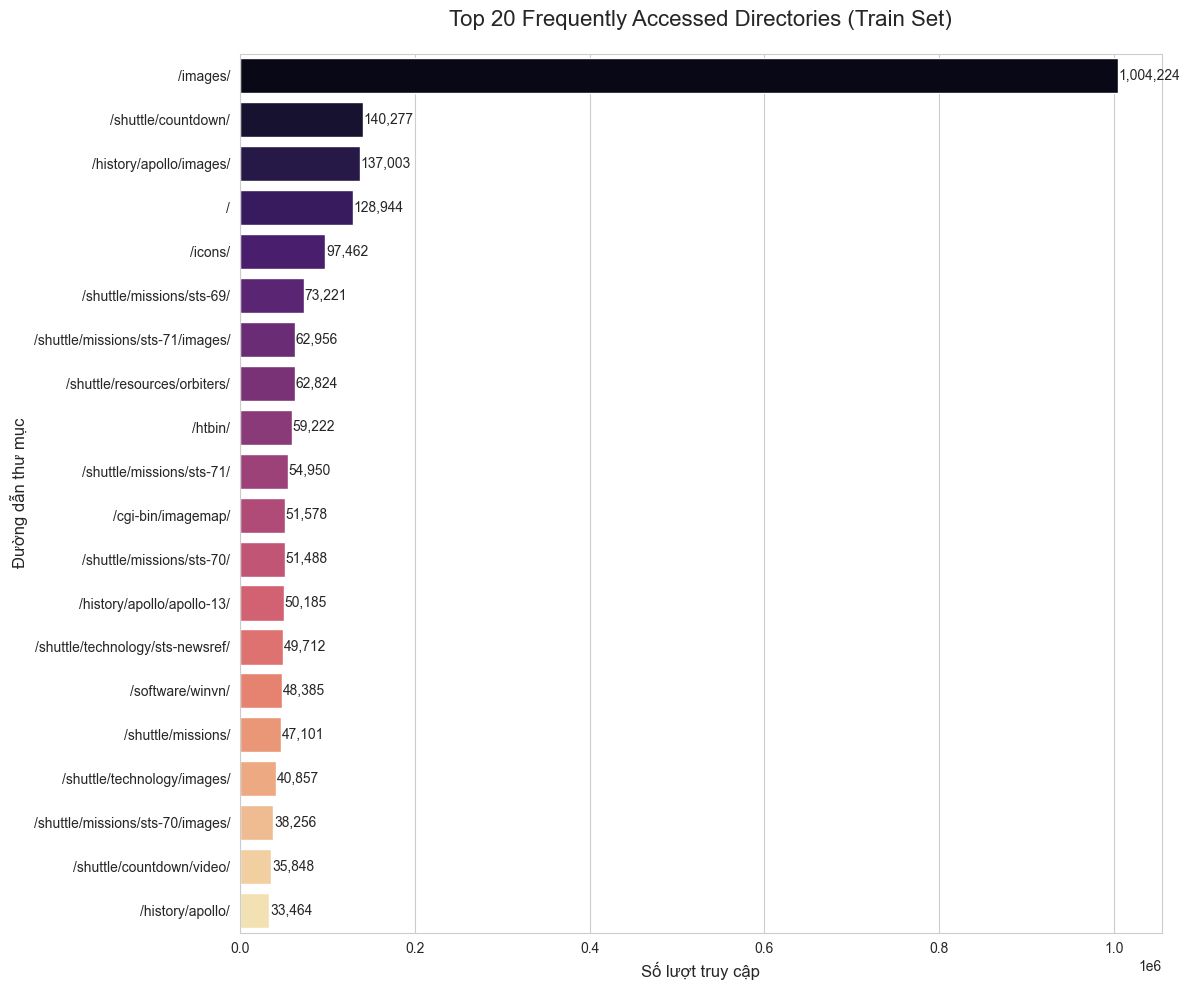

In [43]:
plot_top_directories(df_train_cleaned)

In [45]:
# Đếm số lượng theo loại tài nguyên
def plot_request_type_distribution(df_train_cleaned):
    res_counts = df_train_cleaned['reqresourcetype'].value_counts().reset_index()
    res_counts.columns = ['Type', 'Count']

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    ax = sns.barplot(x='Type', y='Count', data=res_counts, palette='magma')

    plt.title('Phân bổ các loại tài nguyên yêu cầu (Request Type Distribution)')
    plt.yscale('log') # Dùng thang Log vì Image thường nhiều áp đảo Page
    plt.ylabel('Số lượng (Thang Log)')

    # Thêm con số trên đầu cột
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    plt.show()

C:\Users\OS\AppData\Local\Temp\ipykernel_1212\190868758.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Type', y='Count', data=res_counts, palette='magma')


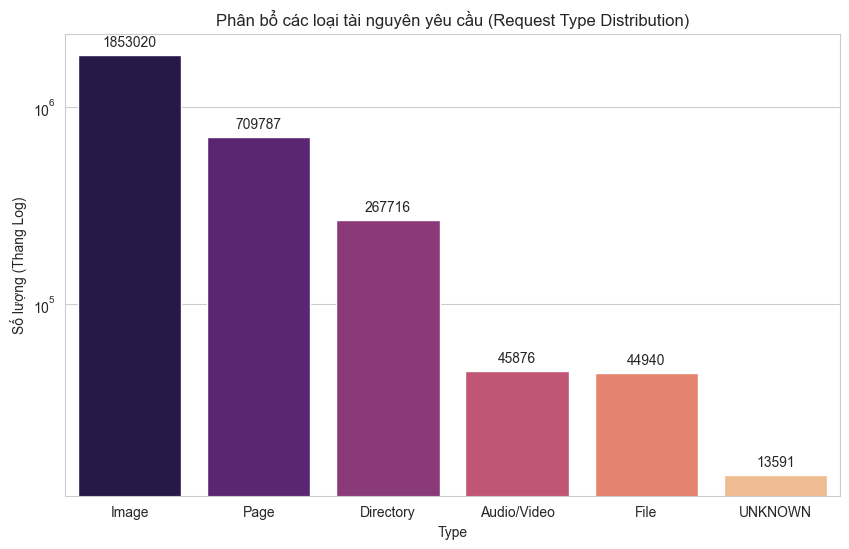

In [47]:
plot_request_type_distribution(df_train_cleaned)